In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df_original = pd.read_csv(r'./housing.csv')
df_original = df_original.fillna(0)

In [3]:
df_full_train, df_test = train_test_split(df_original, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [4]:
features = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "ocean_proximity"]
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

In [5]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Question 1:
#### Train a decision tree regressor to predict `median_house_value` with `max_depth=1`. Which feature is used for splitting the data?
- #### `ocean_proximity=INLAND`
- #### `total_rooms`
- #### `latitude`
- #### `population`

In [6]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [7]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



#### We see that the feature `ocean_proximity=INLAND` is used for splitting the data.

# Question 2
#### Train a random forest model with these parameters
- #### n_estimators=10
- #### random_state=1
- #### n_jobs=-1 (optional to make training faster)
#### What's the RMSE of this model on validation?
- #### 0.05
- #### 0.25
- #### 0.55
- #### 0.85

In [8]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [9]:
y_pred = rf.predict(X_val)
rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 2)
rmse

0.25

#### The RMSE of our random forest regressor model on the validation dataset is 0.25

# Question 3
#### Now let's experiment with the `n_estimators` parameter.
- #### Try different values of this parameter from 10 to 200 with step 10.
- #### Set `random_state` to `1`.
- #### Evaluate the model on the validation dataset.
#### After which value of `n_estimator` does RMSE stop improving?
- #### 10
- #### 50
- #### 70
- #### 150

In [10]:
scores = []


for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred)).round(3)
    
    scores.append((n, rmse))

In [11]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

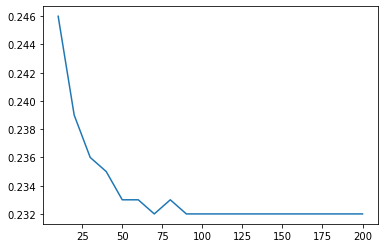

In [12]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

#### After n_estimator=70, the RMSE stops improving

# Question 4
#### Let's select the best `max_depth`:
- #### Try these different values for `max_depth`: `[10, 15, 20, 25]`
- #### For each of these values, try different values of `n_estimators` from 10 to 200 (with step 10)
- #### Fix the random seed: `random_state=1`
#### What's the best `max_depth`:
- #### 10
- #### 15
- #### 20
- #### 25

In [13]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred)).round(3)

        scores.append((d, n, rmse))

In [14]:
cols = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=cols)
df_scores.head()

,max_depth,n_estimators,rmse
0,10,10,0.255
1,10,20,0.253
2,10,30,0.252
3,10,40,0.251
4,10,50,0.250


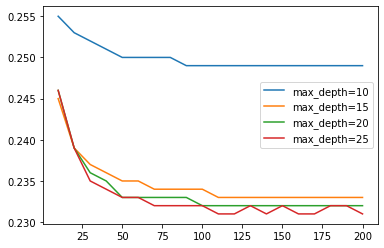

In [15]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' % d)
    
plt.legend()

#### The best max_depth value is 25.

# Question 5
#### We can extract feature importance information from tree-based models. At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models. In scikit-Learn, tree-based models contain this information in the `feature_importances` field.
#### For this homework question we'll find the most important feature. Train the model with these parameters:
- #### `n_estimators=10`
- #### `max_depth=20`
- #### `random_state=1`
- #### `n_jobs=-1` 
#### Get the feature importance from this model. What's the most important feature?
- #### total_rooms
- #### median_income
- #### total_bedrooms
- #### longitude

In [16]:
rf5 = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf5.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [17]:
rf5.feature_importances_

array([1.69573183e-02, 3.30938997e-02, 1.01333971e-01, 9.62649876e-02,
       3.62912907e-01, 3.00723750e-03, 3.10900842e-01, 3.56806263e-04,
       4.48661972e-04, 4.22762446e-03, 3.09180197e-02, 1.90412562e-02,
       2.05364687e-02])

In [21]:
df_feat_imports = pd.DataFrame()
df_feat_imports['feature'] = dv.feature_names_
df_feat_imports['importance'] = rf5.feature_importances_
df_feat_imports.sort_values(by='importance', ascending=False)

,feature,importance
4,median_income,0.362913
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101334
3,longitude,0.096265
1,housing_median_age,0.033094
10,population,0.030918
12,total_rooms,0.020536
11,total_bedrooms,0.019041
0,households,0.016957
9,ocean_proximity=NEAR OCEAN,0.004228


#### We see that the `median_income` feature has the highest importance at 0.362913

# Question 6
#### Now let's train an XGBoost model! For this quesiton, we'll tune the `eta` parameter:
- #### Install XGBoost
- #### Create DMatrix for train and validation
- #### Create a watchlist
- #### Train a model with these paramters for 100 rounds:

`xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}`

#### Now change `eta` from `0.3` to `0.1`
#### Which `eta` value leads to the best RMSE score on the validation dataset?

In [22]:
!pip install xgboost

ERROR: Could not find a version that satisfies the requirement xgboost
ERROR: No matching distribution found for xgboost


In [23]:
import xgboost as xbg

ModuleNotFoundError: No module named 'xgboost'